# Working with FITS files

In [1]:
import numpy as np
# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook
from ipywidgets import *

from astropy.io import fits
import glob

In [2]:
fitsfiles = ["L246309-SB{sb:03d}-UV50_250_natural-I-image_reweighted.fits".format(sb=sb) for sb in range(98,120)]

In [3]:
fits_prefix = "ftp://ftp.astron.nl/outgoing/mevius/fitsfiles/eordata/"

## Read in one FITS file

In [4]:
hdu_list =  fits.open(fits_prefix + fitsfiles[0])
hdu_list.info()

Filename: /home/mevius/.astropy/cache/download/py3/20c201694b9eee242820f1f28f3ef875
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      53   (1500, 1500, 1, 1)   float32   


If you provided `fits.open` with a URL, astropy downloaded the fits file to a temporary directory, which you can inspect with `hdu_list.fileinfo()`:

In [5]:
hdu_list[0].fileinfo()

{'datLoc': 5760,
 'datSpan': 9000000,
 'file': <astropy.io.fits.file._File <_io.FileIO name='/home/mevius/.astropy/cache/download/py3/20c201694b9eee242820f1f28f3ef875' mode='rb' closefd=True>>,
 'filemode': 'readonly',
 'hdrLoc': 0}

To see the entire header as it appears in the FITS file (with the END card and padding stripped), simply enter the header object by itself, or `print(repr(hdu_list[0]))`:

In [6]:
hdu_list[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    4 / number of data axes                            
NAXIS1  =                 1500 / length of data axis 1                          
NAXIS2  =                 1500 / length of data axis 2                          
NAXIS3  =                    1 / length of data axis 3                          
NAXIS4  =                    1 / length of data axis 4                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BSCALE  =                   1.                                                  
BZERO   =                   0.                                                  
BUNIT   = 'JY/BEAM '        

If an HDU’s data is an image, the data attribute of the HDU object will return a numpy ndarray object.

In [7]:
data = hdu_list[0].data

**Exercise**: What kind of data is in here? What is the shape of the data array, what is the minimum, maximum? Can you spot the EOR?

In [8]:
print(np.min(data), np.max(data))
print(data.shape)

-0.08012231 0.069010854
(1, 1, 1500, 1500)


**Exercise**: Plot the data in the image. Use `vmin` and `vmax` of `imshow` to get some good contrast (if you're feeling adventurous, use `np.percentile`).

<IPython.core.display.Javascript object>


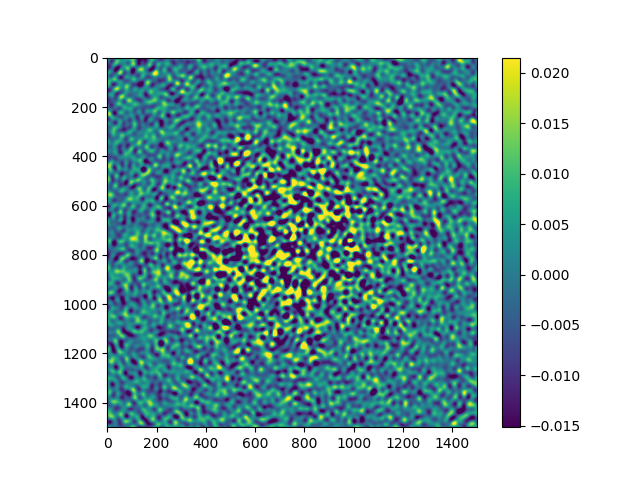

In [15]:
fig, ax = plt.subplots()
cax = ax.imshow(data.squeeze(), vmin=np.percentile(data, 5), vmax=np.percentile(data, 98));
fig.colorbar(cax);


# Adding world axes

Meaningful axes for this image can be added by using the WCS package (for **W**orld **C**oordinate **S**ystem):

In [16]:
from astropy import wcs

In [17]:
mywcs = wcs.WCS(hdu_list[0].header)
mywcs.celestial

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 0.0  90.0  
CRPIX : 751.0  751.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00833333333333333  0.00833333333333333  
NAXIS : 1500  1500  1  1

<IPython.core.display.Javascript object>


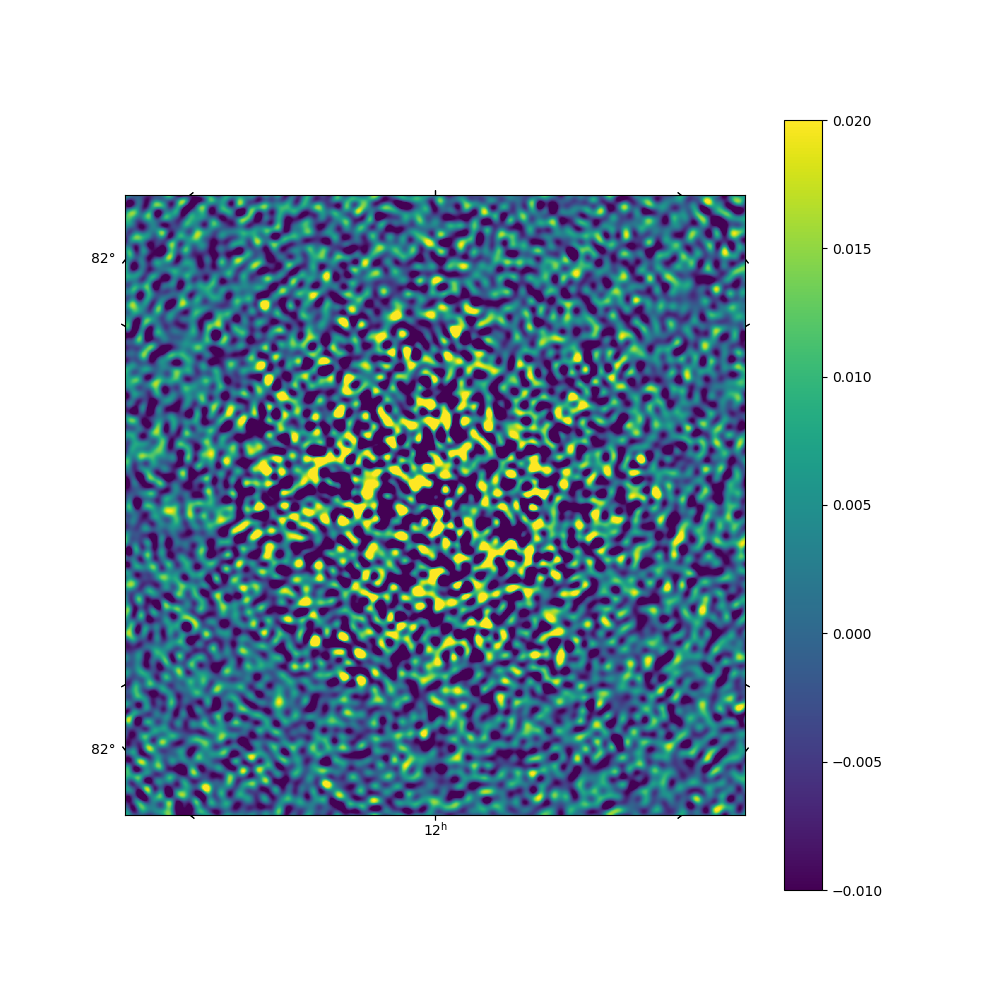

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=mywcs.celestial)

cax = ax.imshow(data.squeeze(),vmin=-0.01,vmax=0.02)
fig.colorbar(cax);

Ok, this is NCP data so the axes look a bit weird...

 **Exercise**: Use wcs.world_to_pixel to find the pixel index of RA=0h00m00, DEC=+89d00m00. 

In [28]:
from astropy.coordinates import SkyCoord
ra="0h00m00"
dec="+89d00m00"
pixel=mywcs.celestial.world_to_pixel(SkyCoord(ra=ra, dec=dec))
print (pixel)

[array(750.00067655), array(869.99360446)]


## Creating a new image file

So far we have demonstrated how to read and update an existing FITS file. But how about creating a new FITS file from scratch? Such tasks are very easy in `astropy` for an image HDU. We’ll first demonstrate how to create a FITS file consisting only the primary HDU with image data.

We will concatenate 20 subbands of data into one FITS file.

First, we create a numpy object for the data part, concatenate the data over the frequency axis. This will take a while if you're downloading all fits files.

In [14]:
data_list = [fits.getdata(fits_prefix + fits_filename) for fits_filename in fitsfiles]

KeyboardInterrupt: 

In [ ]:
data = np.concatenate(data_list, axis=1)

Next, we create a PrimaryHDU object to encapsulate the data:

In [ ]:
hdu = fits.PrimaryHDU(data)

We then create a HDUList to contain the newly created primary HDU, and write to a new file:

In [ ]:
hdul = fits.HDUList([hdu])
hdul.writeto('new1.fits')

In [ ]:
fits.getheader('new1.fits')

We need to put in a more meaning full header. Let's copy it from the original file

In [ ]:
header =  fits.getheader(fits_prefix + fitsfiles[0])

In [ ]:
header

**Note**: You can change/add fields in the header as for a dictionary

# Add to the history field

It's good practice to keep some track of what you did in the history field of a FITS file.

In [ ]:
header['history'] ='Created 2019-03-12, concatenation of NCP SB files'

In [ ]:
header

**Exrecise**: Will the frequency axis be correct? 

In [ ]:
hdu = fits.PrimaryHDU(data, header=header)

In [ ]:
hdu.writeto('new3.fits')

In [ ]:
fits.getheader('new3.fits')

Notice that the value of NAXIS3 is automatically changed

**Exercise** : On ftp://ftp.astron.nl/outgoing/mevius/fitsfiles/ipsdata/ you can find 30 images named wsclean-march--t00[00..29]-image.fits (provided by RAF) that need to be concatenated in time. Try to combine them into a single fitscube. You need to add an extra axis for Time.

In [ ]:
fits_prefix = "ftp://ftp.astron.nl/outgoing/mevius/fitsfiles/ipsdata/"

In [ ]:
fitsfiles = ["wsclean-march--t%04d-image.fits"%i for i in range(30)]
data_list = [fits.getdata(fits_prefix + fits_filename) for fits_filename in fitsfiles]

In [ ]:
data_list=np.array(data_list)

In [ ]:
data_list.shape

In [ ]:
header=fits.getheader(fits_prefix + fitsfiles[0])

In [ ]:
header

In [ ]:
header['history'] = 'concatenated 30 files in time'
header['CTYPE5'] = 'frame number'
header['CRVAL5'] = 1
header['CDELT5'] = 1

In [ ]:
fits.writeto("new4.fits",data_list,header=header)

In [ ]:
fits.getheader("new4.fits")

In [ ]:
mywcs=wcs.WCS(header).celestial

In [ ]:
def plot_image(itime=0):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1, projection=mywcs.celestial)

    cax = ax.imshow(data_list[itime].squeeze(),vmin=0,vmax=40)

In [ ]:
interact(plot_image,itime=(0,29))